In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
# from geopy.distance import distance

In [2]:
PATH = Path('data')
list(PATH.iterdir())

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# from mpl_toolkits.basemap import Basemap
import folium
from folium.plugins import MarkerCluster,FastMarkerCluster

[PosixPath('data/ny.html'),
 PosixPath('data/houston_processed.feather'),
 PosixPath('data/florida.html'),
 PosixPath('data/tx.html'),
 PosixPath('data/houston_ready.feather'),
 PosixPath('data/houston.html'),
 PosixPath('data/location_history.json'),
 PosixPath('data/houston_processed_miles_time_diff.feather')]

In [3]:
df = pd.read_feather(PATH/'houston_ready.feather')

In [4]:
# # recalculate miles differences
# def haversine_array(lat1, lng1, lat2, lng2):
#     lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
#     AVG_EARTH_RADIUS = 6371  # in km
#     lat = lat2 - lat1
#     lng = lng2 - lng1
#     d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
#     h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
#     return h

# lat2 = df.latitude.values.tolist()
# long2 = df.longitude.values.tolist()

# lat1 = df.latitude.shift().values.tolist()
# lat1[0] = lat2[0]
# long1 = df.longitude.shift().values.tolist()
# long1[0] = long2[0]

# km_diff = haversine_array(lat1,long1,lat2,long2) 
# df['mile_diff'] = km_diff * 0.621371 # to miles

In [5]:
# df[df.mile_diff>12].groupby(['year','month','day']).mile_diff.mean()

# df['plane'] = df.mile_diff>12

# # df.to_feather(PATH/'houston_ready.feather')

# df_ground = df[~df.plane].copy().reset_index(drop=True)

year  month  day
2016  4      18      19.314191
      5      31     162.667397
      6      3      708.936381
      10     13     236.593397
      12     21      26.120457
             22     938.012779
             24     139.839309
             26      25.258437
             29      95.911094
2017  1      3      139.469908
Name: mile_diff, dtype: float64


# Mean shift

Clustering technique that attemps to find dense areas of data points. Locate center points of each group with a sliding window: updating group's center points by finding the mean of all points within the window.

Pros: 
- no need to specify number of clusters
- converge towards points of maximum density -> can be suitable for cleaning up this dataset

Cons:
- hypertuning radius of sliding window (windows size)
- not highly scalable as it requires multiple nearest neighbor searches during execution

In [4]:
from sklearn.cluster import MeanShift, estimate_bandwidth
rs=42

In [32]:
bw = estimate_bandwidth(df[['latitude','longitude']],quantile=0.3,
                        n_samples=20000,
                        random_state=rs,n_jobs=-1)

In [33]:
ms = MeanShift(bandwidth=bw, bin_seeding=True)
cluster = ms.fit_predict(df[['latitude','longitude']])

In [34]:
df['cluster'] = cluster

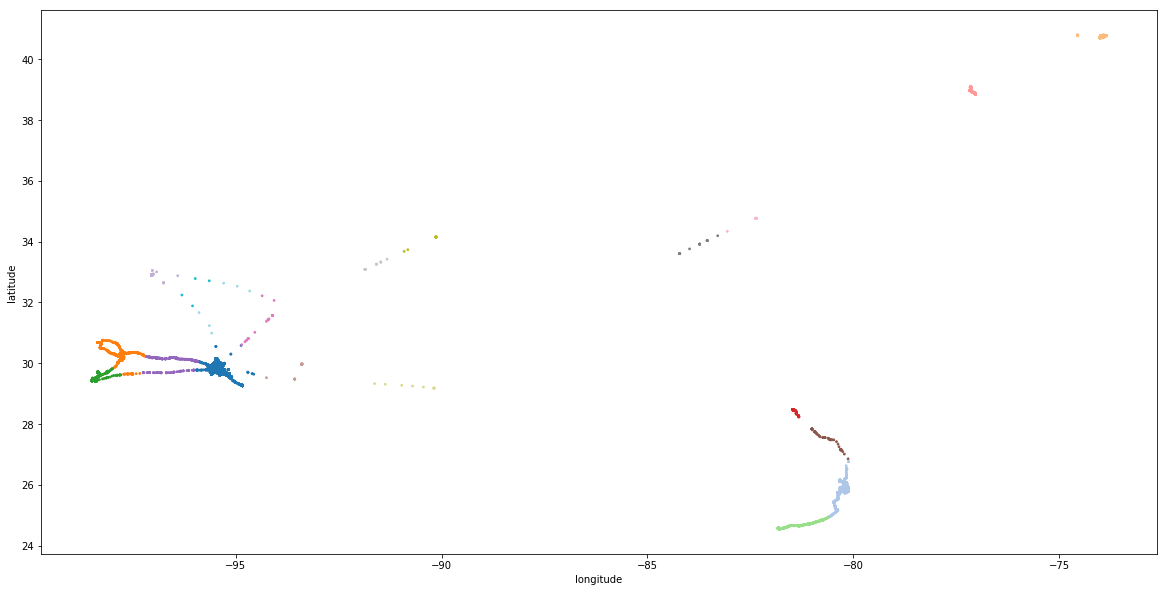

In [35]:
fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df.longitude,df.latitude,c=df.cluster,cmap='tab20',s=3,alpha=1)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')

In [36]:
temp=df.groupby('cluster').size()
temp

cluster
0     320773
1       7436
2       4409
3       3167
4       2247
5        710
6        618
7        515
8        455
9        489
10        74
11        27
12        28
13        23
14        19
15        17
16        18
17        10
18         4
19         3
20         3
dtype: int64

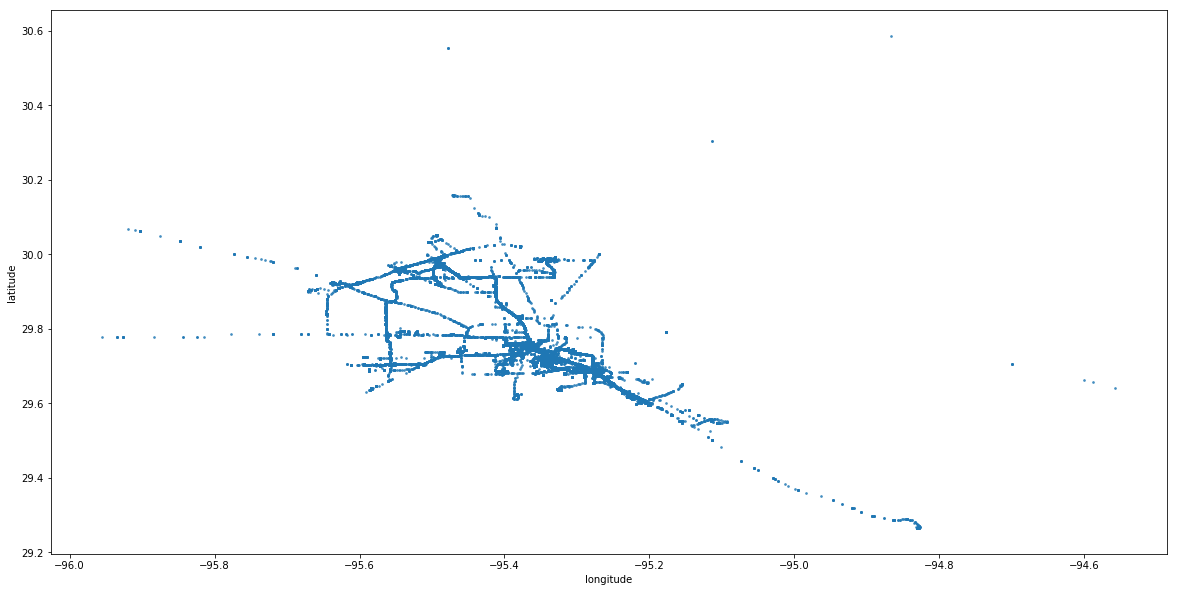

In [37]:
fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df[df.cluster==temp.idxmax()].longitude,
                 df[df.cluster==temp.idxmax()].latitude,cmap='tab10',s=3,alpha=0.7)
_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')

MeanShift clustering fits this dataset better than kmeans due to the fact that it can detect low/high density clusters with its sliding windows. Thus there is no need to preprocess and clean up small group (flight paths)

# Houston clustering

Using low quantile (0.1) results in more cluster groups discovered

In [106]:
df_h = df[(df.cluster==0)].reset_index(drop=True)
df_h.shape

(320773, 24)

In [107]:
bw = estimate_bandwidth(df_h[['latitude','longitude']],quantile=0.1,
                        n_samples=30000,
                        random_state=rs,n_jobs=-1)

In [108]:
ms = MeanShift(bandwidth=bw, bin_seeding=True)
df_h['cluster'] = ms.fit_predict(df_h[['latitude','longitude']])

In [109]:
temp=df_h.groupby('cluster').size()
temp

cluster
0      199561
1       35243
2       34396
3       11432
4        4990
5        3745
6        3777
7        2697
8        1794
9        2297
10       2094
11       1877
12       1422
13       1478
14       1059
15        952
16        736
17        571
18        443
19        440
20        512
21        329
22        337
23        341
24        301
25        340
26        219
27        158
28        173
29        297
        ...  
135         5
136         5
137         5
138         5
139         5
140         4
141         4
142         4
143        45
144         4
145        16
146         4
147         3
148         3
149         2
150         2
151         2
152         2
153        18
154         2
155         2
156         1
157         1
158         1
159         1
160         1
161         1
162         1
163         1
164         1
Length: 165, dtype: int64

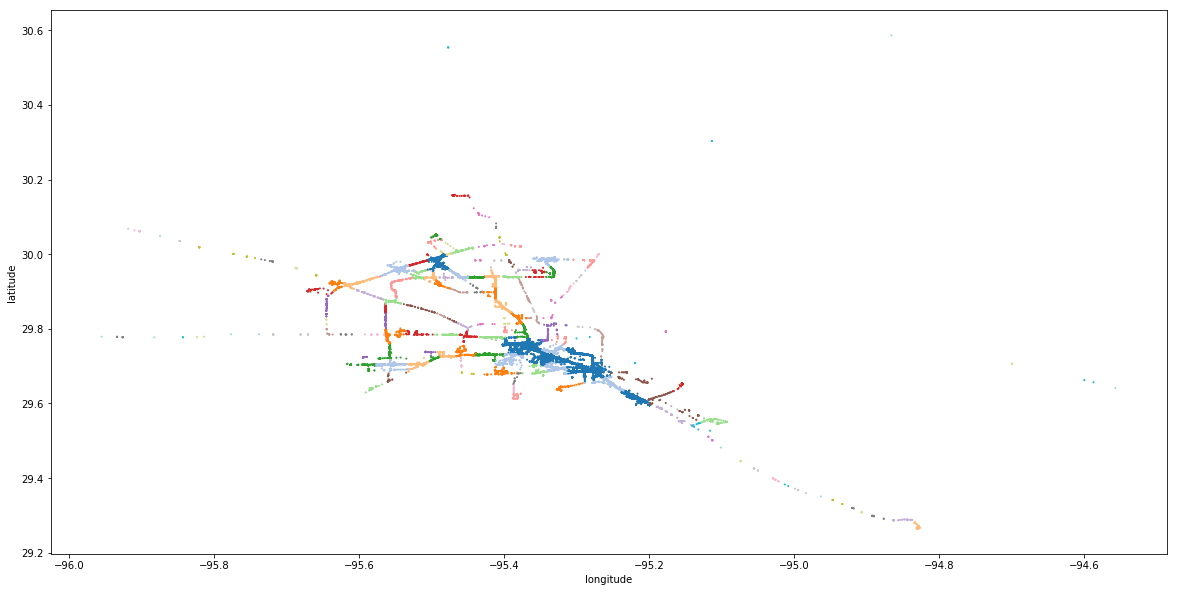

In [96]:
#0.1
fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df_h.longitude,df_h.latitude,c=df_h.cluster,cmap='tab20',s=1,alpha=1)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')

## Top 6 groups

In [110]:
temp = df_h.groupby('cluster').size()

temp.nlargest(n=6)

idx_maxes=temp.nlargest(n=6).index.values

cluster
0    199561
1     35243
2     34396
3     11432
4      4990
6      3777
dtype: int64

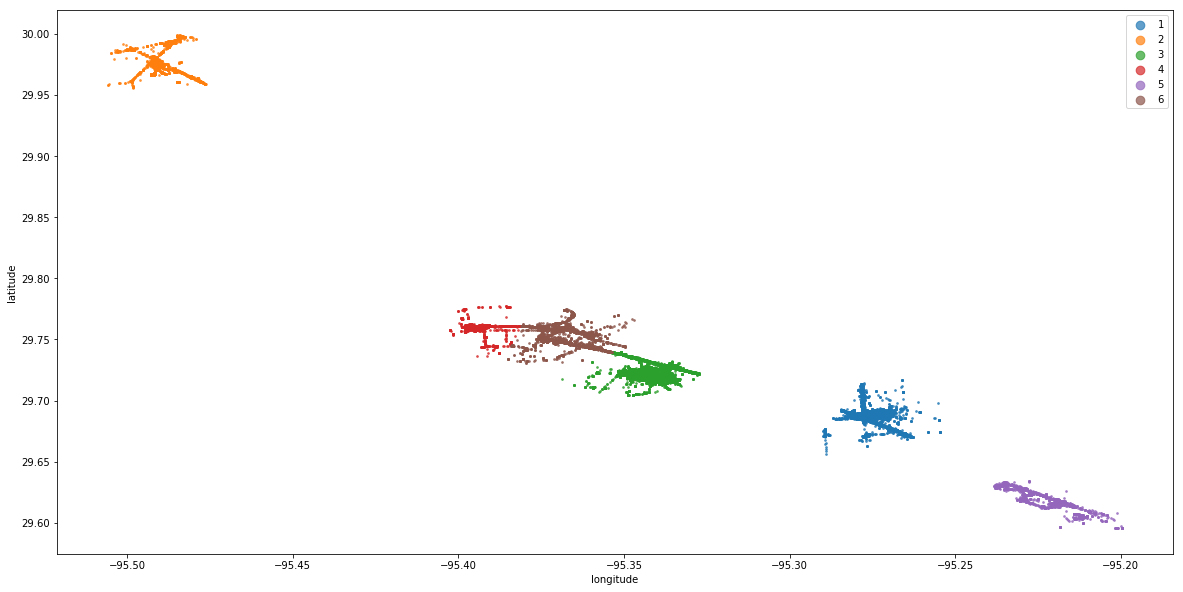

In [111]:
fig,ax = plt.subplots(figsize=(20,10))
for i,i_max in enumerate(idx_maxes):    
    _=ax.scatter(df_h[df_h.cluster==i_max].longitude,
                 df_h[df_h.cluster==i_max].latitude,cmap='tab20',s=3,alpha=0.7,label=f'{i+1}')
_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')
_=ax.legend(markerscale=5)

As stated before, meanshift did a better job at discover large and small cluster group which makes it easier to filter out and focus on important clusters. There is no need to filter out commute paths manually.

In [113]:
df_lrg_cluster = df_h[df_h.cluster.isin(np.delete(idx_maxes,1))].copy().reset_index(drop=True)
df_lrg_cluster.shape

(254156, 24)

# Habit analysis

In [114]:
# weekend
df_lrg_cluster['is_weekend'] = ~df_lrg_cluster.day_of_week.isin(np.arange(0,5))

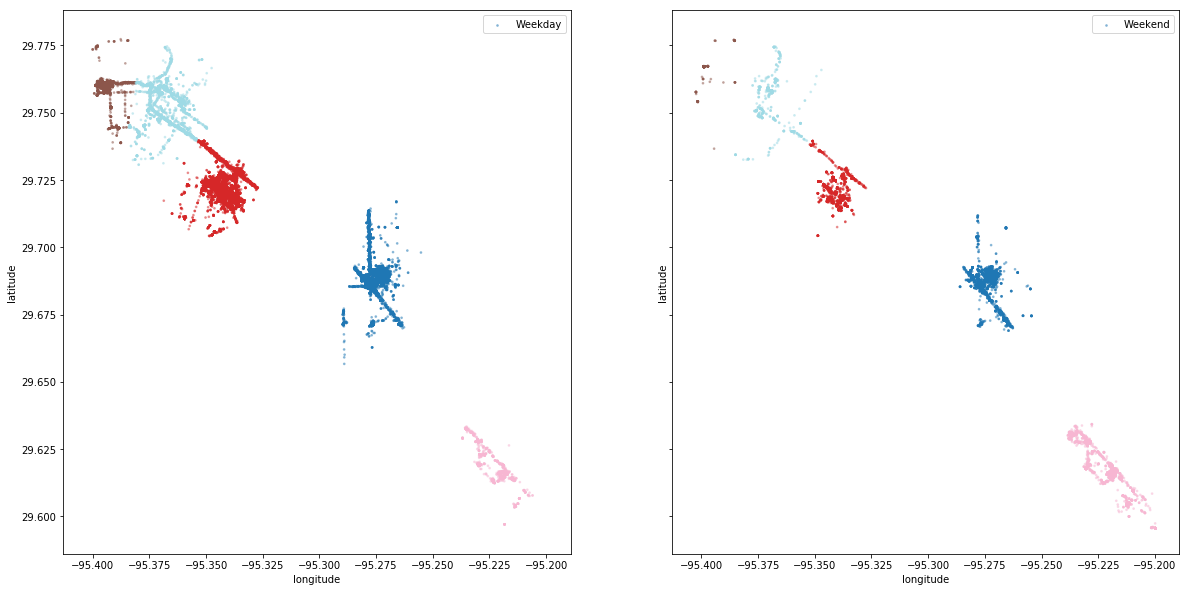

In [115]:
# weekday vs weekend

wd = df_lrg_cluster[~df_lrg_cluster.is_weekend]
we = df_lrg_cluster[df_lrg_cluster.is_weekend]
fig,axes = plt.subplots(ncols=2,figsize=(20,10),sharex=True,sharey=True)
_=axes[0].scatter(wd.longitude,
                 wd.latitude,c=wd.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekday')
_=axes[1].scatter(we.longitude,
                 we.latitude,c=we.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekend')
_=axes[0].set_ylabel('latitude')
_=axes[0].set_xlabel('longitude')
_=axes[0].legend()
_=axes[1].set_ylabel('latitude')
_=axes[1].set_xlabel('longitude')
_=axes[1].legend()

In [116]:
# day-night
df_lrg_cluster['is_night'] = ~df_lrg_cluster.hour.isin(np.arange(9,20)) #day is from 9 am to 7:59 pm

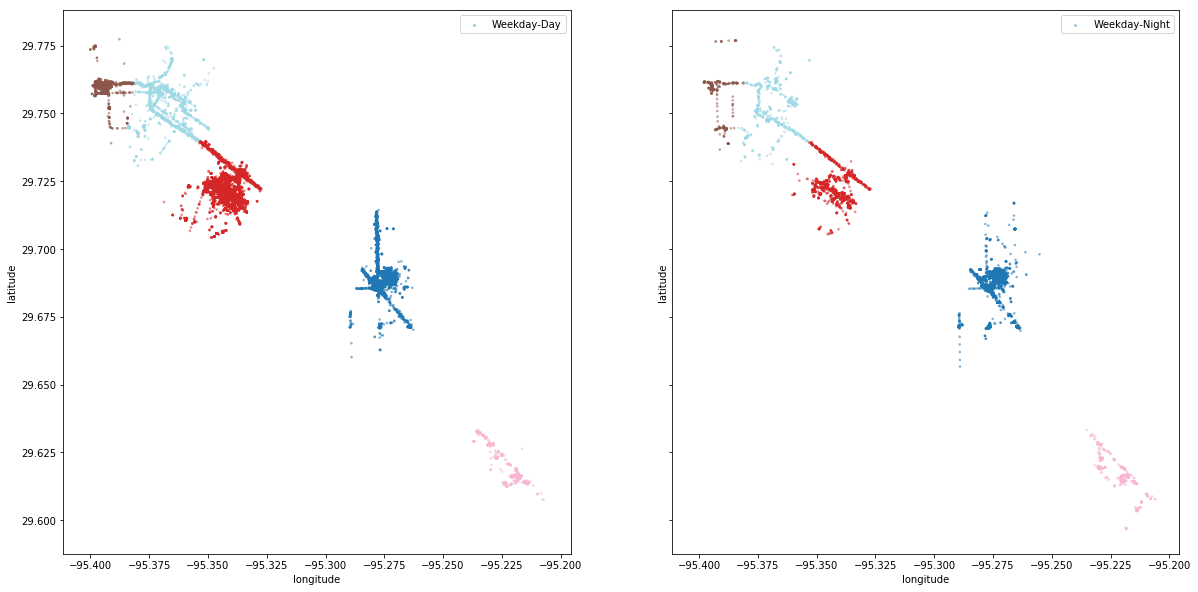

In [117]:
# weekday day vs night
wd_day = df_lrg_cluster[(~df_lrg_cluster.is_weekend) & (~df_lrg_cluster.is_night)]
wd_night = df_lrg_cluster[(~df_lrg_cluster.is_weekend) & (df_lrg_cluster.is_night)]

fig,axes = plt.subplots(ncols=2,figsize=(20,10),sharex=True,sharey=True)
_=axes[0].scatter(wd_day.longitude,
                 wd_day.latitude,c=wd_day.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekday-Day')
_=axes[1].scatter(wd_night.longitude,
                 wd_night.latitude,c=wd_night.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekday-Night')
_=axes[0].set_ylabel('latitude')
_=axes[0].set_xlabel('longitude')
_=axes[0].legend()
_=axes[1].set_ylabel('latitude')
_=axes[1].set_xlabel('longitude')
_=axes[1].legend()

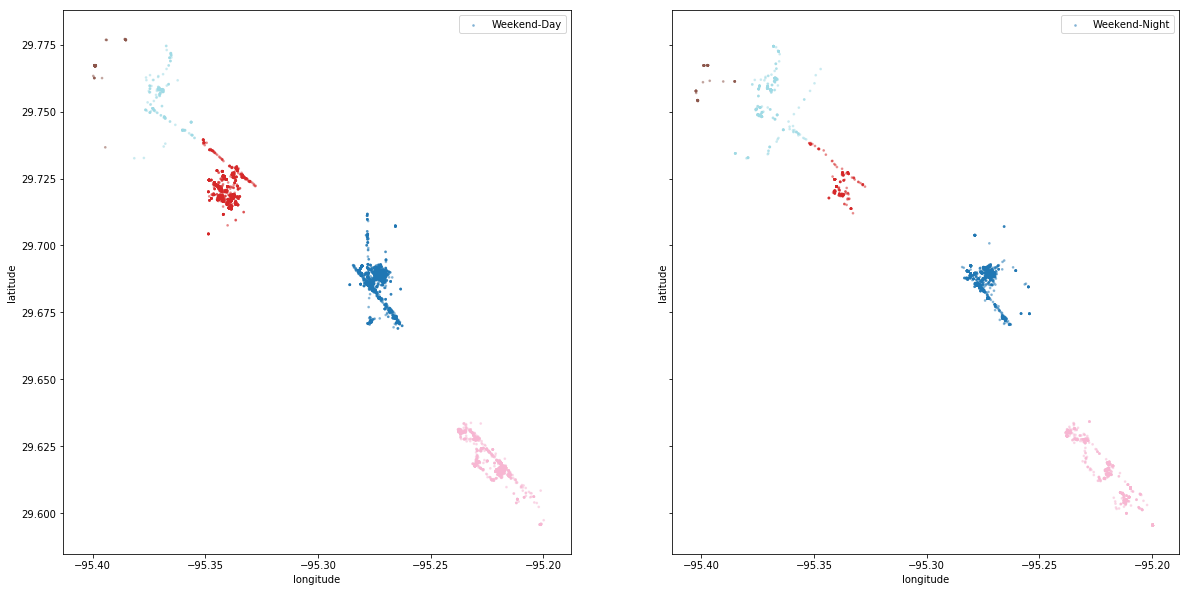

In [118]:
# weekend day vs night
we_day = df_lrg_cluster[(df_lrg_cluster.is_weekend) & (~df_lrg_cluster.is_night)]
we_night = df_lrg_cluster[(df_lrg_cluster.is_weekend) & (df_lrg_cluster.is_night)]

fig,axes = plt.subplots(ncols=2,figsize=(20,10),sharex=True,sharey=True)
_=axes[0].scatter(we_day.longitude,
                 we_day.latitude,c=we_day.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekend-Day')
_=axes[1].scatter(we_night.longitude,
                 we_night.latitude,c=we_night.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekend-Night')
_=axes[0].set_ylabel('latitude')
_=axes[0].set_xlabel('longitude')
_=axes[0].legend()
_=axes[1].set_ylabel('latitude')
_=axes[1].set_xlabel('longitude')
_=axes[1].legend()